In [2]:
# ============================================================
# Notebook setup: run this before everything
# ============================================================

from sklearn.model_selection import GridSearchCV
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os

%load_ext autoreload
%autoreload 2

from util import util_ad_hd as util

# Control figure size
figsize=(14, 4)

# Load data
data_file = os.path.join('..', 'data', 'hpc.csv')
hpc = pd.read_csv(data_file, parse_dates=['timestamp'])

# Identify input columns
inputs = hpc.columns[1:-1]
ninputs = len(inputs)

# Autoencoders for Anomaly Detection

## Autoencoders

**An autoencoder is _a type of neural network_**

* The network is designed to _reconstruct its input vector_
* The input is a tensor $x$ and the output _should be similar_ to the same tensor $x$

<center>
<img src="assets/ae.png" width=50%/>
    <span style="font-size:small">Figure from Wikipedia</span>
</center>

## Autoencoders

**Autoencoders can be broken down in two halves**

* An encoder, i.e. $\mathit{e}(x, \theta_e)$, mapping $x$ into a vector of _latent variables $z$_
* A decoder, i.e. $\mathit{d}(z, \theta_d)$, mapping $z$ into reconstructed input tensor

<center>
<img src="assets/ae.png" width=50%/>
    <span style="font-size:small">Figure from Wikipedia</span>
</center>

## Training an Autoencoder

**Autoencoders are typically trained for minimum MSE:**

$$
\mathop{\arg\min}_{\theta_e, \theta_d} \| \mathit{d}(\mathit{e}(x_i, \theta_e), \theta_d) - x_i\|_2^2
$$

* I.e. $\mathit{d}$, when applied to the output of $\mathit{e}$
* ...Should approximately return the input vector itself

A nice tutorial about autoencoders can be found [on the Keras blog](https://blog.keras.io/building-autoencoders-in-keras.html)

**There is a risk that an autoencoder learns a trivial transformation ($x^\prime = x$)**

This is obviously undesired, and it can be avoided by:

* Choosing a small-dimensional latent space (_compressing_ autoencoder)
* By encouraging sparse encodings with an L1 regularizer (_sparse_ autoencoder)

## Autoencoders for Anomaly Detection

**Autoencoders can be used for anomaly detection**

...By using the _reconstruction error as an anomaly signal_, e.g.:

$$
\left\|x - \mathit{d}(\mathit{e}(x, \theta_e), \theta_d)\right\|_2^2 \geq \theta
$$

**This approach has some PROs and CONs compared to KDE**

* The _size of a Neural Network_ does not depend on the size of the training set
* Neural Networks have good _support for high dimensional data_
* ...Plus _limited overfitting_ and _fast prediction/detection time_
* However, input reconstruction can be _harder than density estimation_

**Let's prepare the data to test the approach**

<div class=big>Shall we standardize/normalize the data? And why?</div>

## NNs and Standardization

**Normalization is important for NNs, due to the use of _gradient descent_**

The performance of SGD depends a lot on its starting point

* DL libraries all come with robust weight initialization procedures
  - ...And robust default parameters for the gradient descent algorithms
* ...But those are designed for data that is:
  - Reasonably _close to zero_
  - Mostly _contained in a $[-1, 1]^n$ box_

**You _can_ use NNs with non standardize data**

...But expect _far less reliable_ results

* In addition, vector output should _always_ be standardized/normalized
* We'll see why in a short while

## Data Preparation

**We'll prepare our data as we did for KDE**

First we apply a standardization step:

In [3]:
tr_end, val_end = 3000, 4500
hpcs = hpc.copy()
tmp = hpcs.iloc[:tr_end]
hpcs[inputs] = (hpcs[inputs] - tmp[inputs].mean()) / tmp[inputs].std()

The we separate a training, validation, and test set

In [4]:
trdata = hpcs.iloc[:tr_end]
valdata = hpcs.iloc[tr_end:val_end]
tsdata = hpcs.iloc[val_end:]

## Building an Autoencoder

**The we can build an autoencoder (we'll use tensorflow 2.0 and keras)**

First, we build the model using (e.g.) the functional API

In [5]:
import keras
from keras import layers, callbacks

input_shape = (len(inputs), )
ae_x = keras.Input(shape=input_shape, dtype='float32')
ae_z = layers.Dense(64, activation='relu')(ae_x)
ae_y = layers.Dense(len(inputs), activation='linear')(ae_z)
ae = keras.Model(ae_x, ae_y)

* `Input` builds the entry point for the input data
* `Dense` builds a fully connected layer
* "Calling" layer A with parameter B attaches B to A
* `Model` builds a model object with the specified input and output

## Autoencoders in Keras

**Then we can prepare our model for training**

In keras terms, we _compile_ it

In [6]:
ae.compile(optimizer='Adam', loss='mse')

* We are using the `Adam` optimizer (a variant of Stochastic Gradient Descent)

**Then we can start training:**

In [7]:
cb = [callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
history = ae.fit(trdata[inputs], trdata[inputs], validation_split=0.1,
                 callbacks=cb, batch_size=32, epochs=30, verbose=0)

* We are using a callback to stop training early
* ...If no improvement on the validation set is observed for 3 epochs

## Autoencoders in Keras

**Let's have a look at the loss evolution over different epochs**

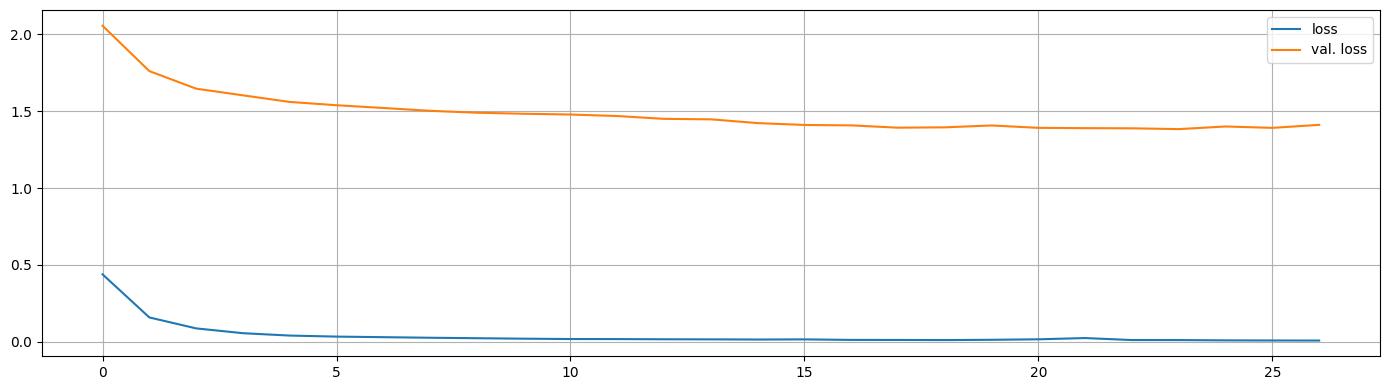

In [8]:
util.plot_training_history(history, figsize=figsize)

## Autoencoders in Keras

**Finally, we can obtain the predictions**

In [9]:
preds = pd.DataFrame(index=hpcs.index, columns=inputs, data=ae.predict(hpcs[inputs], verbose=0))
preds.head()

,ambient_temp,cmbw_p0_0,cmbw_p0_1,cmbw_p0_10,cmbw_p0_11,cmbw_p0_12,cmbw_p0_13,cmbw_p0_14,cmbw_p0_2,cmbw_p0_3,...,util_p0_4,util_p0_5,util_p0_6,util_p0_8,util_p0_9,volt_v0_1,volt_v0_2,volt_v1_1,volt_v1_2,winkcnt_p0_2
0,-1.414166,-1.399190,0.241891,1.693468,2.040897,1.790998,1.716491,1.900154,-0.967087,-1.048273,...,-0.292967,-1.689537,-0.978321,2.140911,1.962068,-6.475839,1.719572,-6.173369,2.187341,2.514860
1,-0.802001,-0.534030,0.324981,2.182271,2.325772,2.268217,2.234467,2.220423,0.365094,-0.704607,...,0.748663,0.537145,0.230649,1.915686,2.544379,0.052549,2.217857,0.040955,2.079132,2.092255
2,-1.004940,-0.994740,-0.386334,2.368342,2.337509,2.426816,2.356327,2.266239,0.613221,0.709304,...,0.948582,-0.802258,0.140557,2.078887,2.768486,0.207596,2.370357,0.286352,2.403006,2.405687
3,-0.777538,-0.840914,-0.509004,2.256818,2.314422,2.294407,2.215047,2.178997,0.818741,0.677289,...,1.006087,0.701910,-1.528603,2.003086,2.614352,0.330054,2.305120,0.236668,2.318056,2.278729
4,-0.986344,-0.957748,-0.516556,2.290415,2.334587,2.300023,2.264766,2.237829,0.806280,0.861571,...,0.979420,0.662602,-1.556405,2.070243,2.679198,0.213377,2.289880,0.253650,2.292100,2.248785


* These are the reconstructed values for all the input features

## Alarm Signal

**We can finally obtain our alarm signal, i.e. the sum of squared errors**

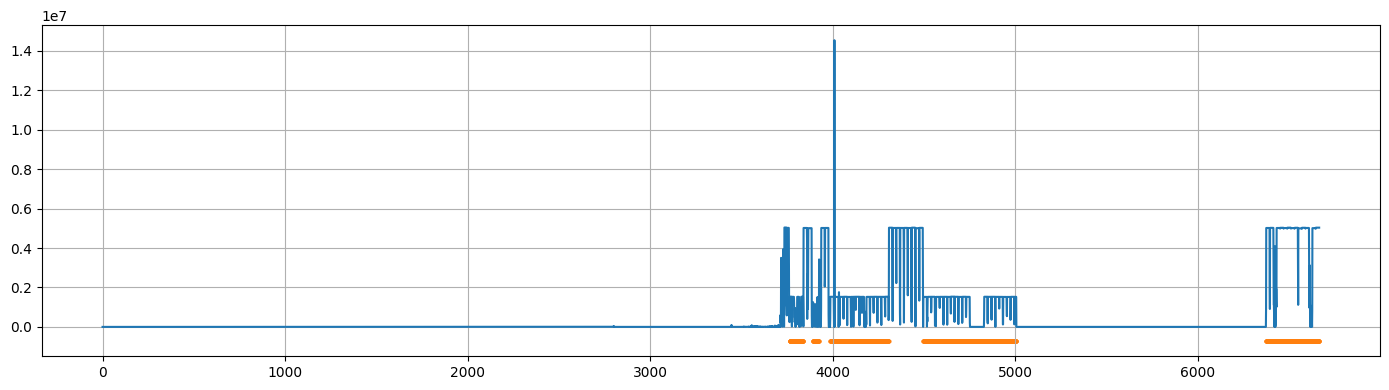

In [10]:
labels = pd.Series(index=hpcs.index, data=(hpcs['anomaly'] != 0), dtype=int)
sse = np.sum(np.square(preds - hpcs[inputs]), axis=1)
signal_ae = pd.Series(index=hpcs.index, data=sse)
util.plot_signal(signal_ae, labels, figsize=figsize)

> **This is very similar to the KDE and GMM signal: why?**

## Semantic of Neural Regressors

**Let's try to understand what we have just done**

When we train an autoencoder (renamed here as $h$), we solve:

$$
\mathop{\arg\min}_{\theta} \| h(x, \theta) - x\|_2^2
$$

By expanding the L2 norm, we get:

$$
\mathop{\arg\min}_{\theta} \sum_{i=1}^m \sum_{j=1}^n \left(h_j(x_i, \theta) - x_{i,j}\right)^2
$$

By introducing a $\log$ and $\exp$ transformation we obtain:

$$
\mathop{\arg\min}_{\theta} \log \exp\left(\sum_{i=1}^m \sum_{j=1}^n \left(h_j(x_i, \theta) - x_{i,j}\right)^2\right)
$$

## Semantic of Neural Regressors

**Then, from the last step:**

$$
\mathop{\arg\min}_{\theta} \log \exp\left(\sum_{i=1}^m \sum_{j=1}^n \left(h_j(x_i, \theta) - x_{i,j}\right)^2\right)
$$

We rewriting the outer sum using properties of exponentials:

$$
\mathop{\arg\min}_{\theta} \log \prod_{i=1}^m \exp\left(\sum_{j=1}^n \left(h_j(x_i, \theta) - x_{i,j}\right)^2\right)
$$

Then we rewrite the inner sum in matrix form:

$$
\mathop{\arg\min}_{\theta} \log \prod_{i=1}^m \exp\left(\left(h(x_i, \theta) - x_{i,j}\right)^T I \left(h(x_i, \theta) - x_{i,j}\right) \right)
$$

## Semantic of Neural Regressors

**Starting from the last step:**

$$
\mathop{\arg\min}_{\theta} \log \prod_{i=1}^m \exp\left(\left(h(x_i, \theta) - x_{i,j}\right)^T I \left(h(x_i, \theta) - x_{i,j}\right) \right)
$$

We make a few adjustment that do not change the optimal solution:

* We negate the argument of $\exp$ and swap the $\arg\min$ for a $\arg\max$
* We multiply exponent by $1/2 \sigma$ (for some constant $\sigma$)
* We multiply the exponential by $1/\sqrt{2\pi}\sigma$

$$
\mathop{\arg\max}_{\theta} \log \prod_{i=1}^m \frac{1}{\sqrt{2\pi}\sigma} \exp\left(-\frac{1}{2}\left(h(x_i, \theta) - x_{i,j}\right)^T (\sigma I) \left(h(x_i, \theta) - x_{i,j}\right) \right)
$$

## Semantic of Neural Regressors

**Let's look at our last formulation:**

$$
\mathop{\arg\max}_{\theta} \log \prod_{i=1}^m \frac{1}{\sqrt{2\pi}} \exp\left(-\frac{1}{2}\left(h(x_i, \theta) - x_{i,j}\right)^T (\sigma I) \left(h(x_i, \theta) - x_{i,j}\right) \right)
$$

The term inside the product is the PDF of a [multivariate normal distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution)

$$
\mathop{\arg\max}_{\theta} \log \prod_{i=1}^m f\left(x_i, h(x_i), \sigma I\right)
$$

* In particular a distribution _centered on $h(x_i)$_
* ...With _independent Normal components_
* ...All having _uniform variance_

## Semantic of Neural Regressors

**Let's discuss some implications**

When we use a MSE loss, we are _training for maximum likelihood_

* ...Just like density estimators!
* This is actually true for _many_ ML approaches

The _output_ of a (MSE trained) regressor has a _probabilistic interpretation_

* Specifically, the output is the _mean of a conditional distribution_
* The distribution represents the _variability of the target_
* ...Once the effect of the input is taken into account
* Another way to think of it: _noise_ around the prediction


## Semantic of Neural Regressors

**Let's discuss some implications**

We are implicitly assuming that the _noise is normally distributed_

* This true in many cases, but not always
* E.g., sometimes large values are under-represented
* ....Leading to log-normal distributions
* In this cases, applying a log transformation to the output can be very effective

We are also assuming that the all output components _have the same variance_

* This is another (very) good reason to standardize the output

## Semantic of Neural Regressors

**Let's discuss some implications**

We are also assuming that the _noise on all output components is independent_

* This might be true even if the output components themselves are correlated
* ...But still it is not true in all cases

All these implicit assumption can make the problem _harder_

* This is why error reconstruction can be harder than density estimation

Finally, our _alarm signal_ can be interpreted as a _density_:

* To see why, just apply the transformation to $\left\|x - \mathit{d}(\mathit{e}(x, \theta_e), \theta_d)\right\|_2^2$
* This fact explains why the signal is similar to the KDE one

## Threshold Optimization

**The threshold can be optimized as usual**

In [11]:
c_alarm, c_missed, tolerance = 1, 5, 12
cmodel =  util.HPCMetrics(c_alarm, c_missed, tolerance)
th_range = np.linspace(1e4, 2e5, 200)

th_ae, val_cost_ae = util.opt_threshold(signal_ae[tr_end:val_end], hpcs['anomaly'][tr_end:val_end], th_range, cmodel)
print(f'Best threshold: {th_ae:.3f}')
tr_cost_ae = cmodel.cost(signal_ae[:tr_end], hpcs['anomaly'][:tr_end], th_ae)
print(f'Cost on the training set: {tr_cost_ae}')
print(f'Cost on the validation set: {val_cost_ae}')
ts_cost_ae = cmodel.cost(signal_ae[val_end:], hpcs['anomaly'][val_end:], th_ae)
print(f'Cost on the test set: {ts_cost_ae}')

Best threshold: 119798.995
Cost on the training set: 0
Cost on the validation set: 263
Cost on the test set: 265


* The performance is similar to KDE (not surprisingly)

## Mutiple Signal Analysis

**But autoencoders do _more than just anomaly detection_!**

* Instead of having a single signal we have _many_
* So we can look at the _individual_ reconstruction errors

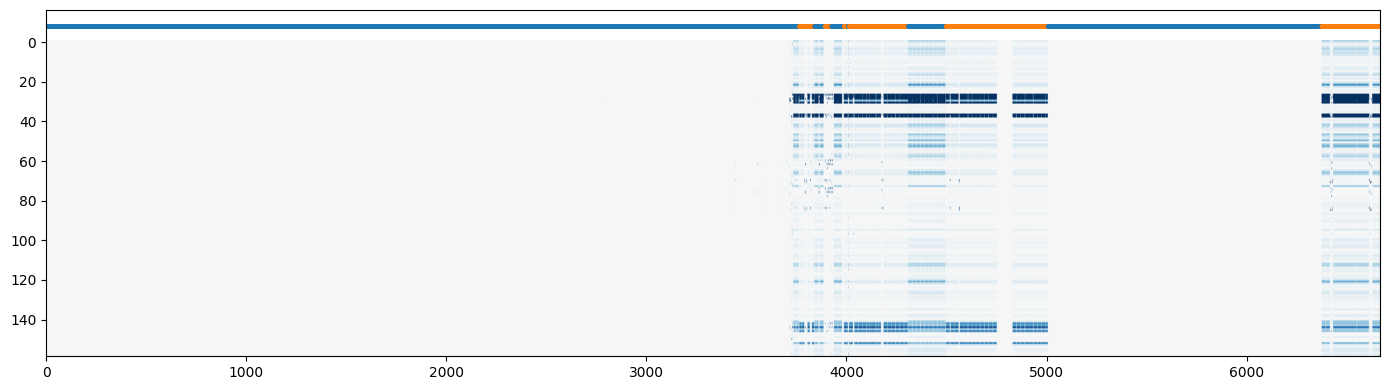

In [12]:
se = np.square(preds - hpcs[inputs])
signals_ae = pd.DataFrame(index=hpcs.index, columns=inputs, data=se)
util.plot_dataframe(signals_ae, labels, vmin=-5e4, vmax=5e4, figsize=figsize)

## Mutiple Signal Analysis

**Reconstruction errors are often concentrated on a few signals**

* These correspond to the properties of the input vector that were harder to reconstruct
* ...And often they are useful clues about the _nature of the anomaly_

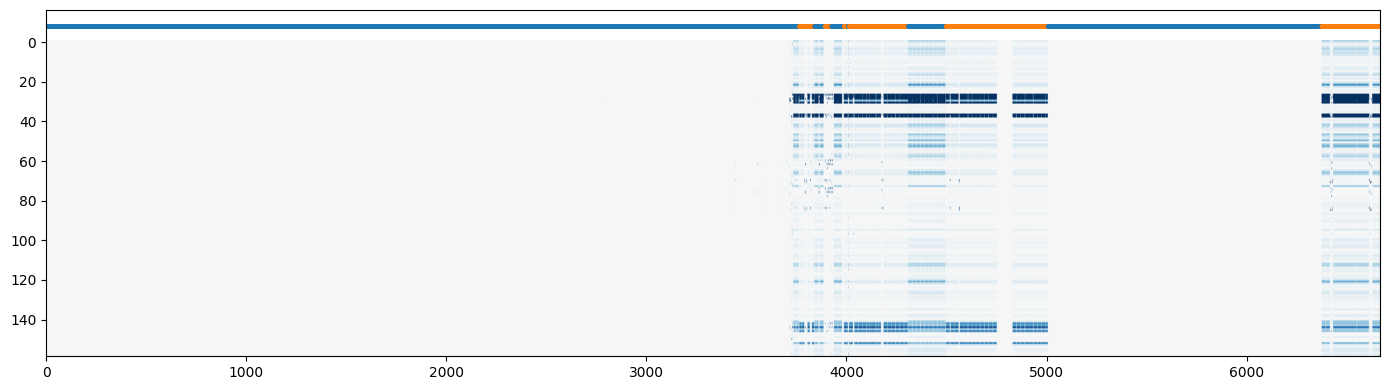

In [13]:
se = np.square(preds - hpcs[inputs])
signals_ae = pd.DataFrame(index=hpcs.index, columns=inputs, data=se)
util.plot_dataframe(signals_ae, labels, vmin=-5e4, vmax=5e4, figsize=figsize)

## Multiple Signal Analysis

**Here are the _average errors_ for all anomalies (sorted by decreasing value)**

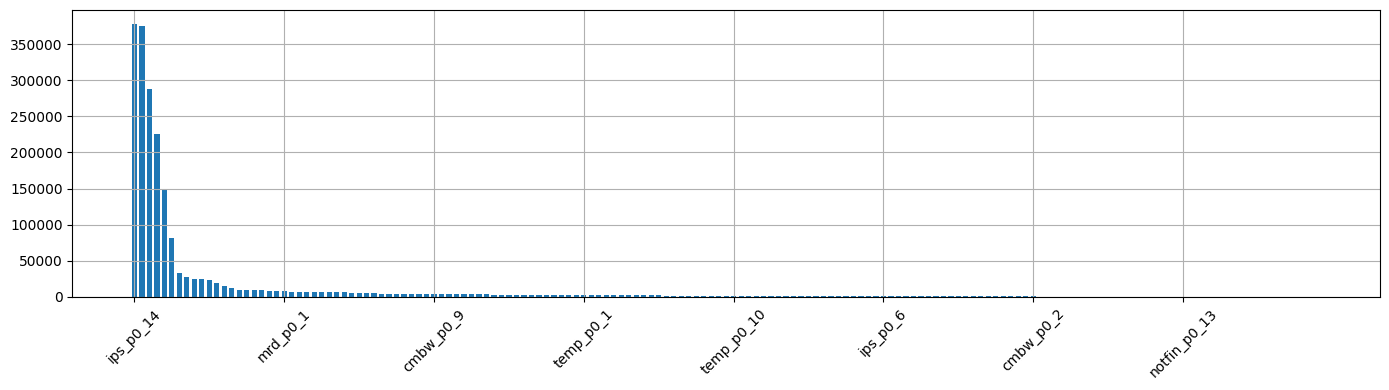

In [14]:
mode_1 = hpcs.index[hpcs['anomaly'] != 0]
tmp =  se.iloc[mode_1].mean().sort_values(ascending=False)
util.plot_bars(tmp, tick_gap=20, figsize=figsize)

* Errors are concentrated on 10-20 features

## Multiple Signal Analysis

**These are the 20 _largest_ average errors for all anomalies**

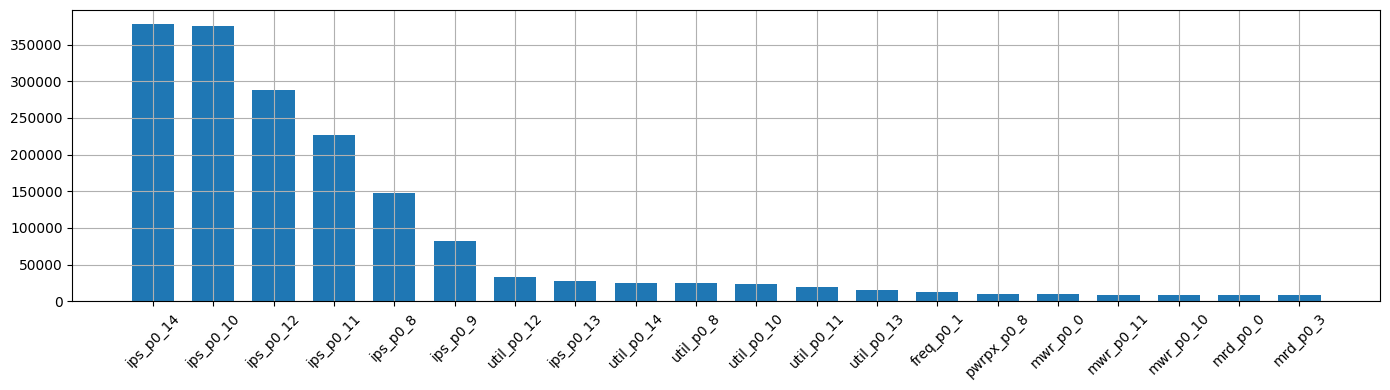

In [15]:
mode_1 = hpcs.index[hpcs['anomaly'] != 0]
tmp =  se.iloc[mode_1].mean().sort_values(ascending=False)
util.plot_bars(tmp.iloc[:20], figsize=figsize)

* The largest errors are on "ips", then on "util" (utilization)
* This kind of information can be _very valuable_ for a domain expert!